In [1]:
!pip install segmentation-models-pytorch albumentations --quiet

import os
import shutil
from google.colab import files

print("Uplaod archive.zip ")
uploaded = files.upload()

# Extract
!unzip -q archive.zip

# Folder name
!ls


if os.path.exists("Semantic segmentation dataset"):
    if os.path.exists("dataset"):
        shutil.rmtree("dataset")
    shutil.move("Semantic segmentation dataset", "dataset")
elif os.path.exists("Semantic-segmentation-of-aerial-imagery"):
    shutil.move("Semantic-segmentation-of-aerial-imagery", "dataset")
else:
    print("Folder name:")
    !ls

print("\nDATASET READY")

# Assuming the structure is dataset/Tile 1/images and dataset/Tile 1/masks

images_path = "dataset/Tile 1/images"
masks_path = "dataset/Tile 1/masks"

if os.path.exists(images_path) and os.path.exists(masks_path):
    print("Images:", len(os.listdir(images_path)))
    print("Masks: ", len(os.listdir(masks_path)))

    # Show starting 5 files
    !echo "\nImages:"
    !ls "{images_path}" | head -5
    !echo "\nMasks:"
    !ls "{masks_path}" | head -5
else:
    print(f"Error: Expected image directory at '{images_path}' and mask directory at '{masks_path}' not found.")
    print("Please check the structure of your unzipped archive. Here's a recursive listing of the 'dataset' folder:")
    !ls -R dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.0 MB/s eta 0:00:00
Uplaod archive.zip 


Saving archive.zip to archive.zip
 archive.zip   sample_data  'Semantic segmentation dataset'

DATASET READY
Images: 9
Masks:  9
\nImages:
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
\nMasks:
image_part_001.png
image_part_002.png
image_part_003.png
image_part_004.png
image_part_005.png


In [3]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [4]:
DATASET_ROOT = "dataset"
IMG_SIZE = 256
SEED = 42
BATCH = 4
EPOCHS = 60
LR = 1e-4
DROPOUT = 0.3

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [26]:
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

def combined_loss(y_true, y_pred):
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return ce + dice_loss(y_true, y_pred)

In [6]:
def load_dataset(root, img_size):
    images = []
    masks = []

    root = Path(root)
    tile_folders = [f for f in root.iterdir() if f.is_dir()]

    for tile in tile_folders:
        img_dir = tile / "images"
        mask_dir = tile / "masks"

        if not img_dir.exists() or not mask_dir.exists():
            print("Missing folder →", tile)
            continue

        img_files = sorted(img_dir.glob("*"))
        mask_files = sorted(mask_dir.glob("*"))

        mask_lookup = {m.stem: m for m in mask_files}

        for img_path in img_files:
            stem = img_path.stem
            if stem not in mask_lookup:
                continue

            # Image
            im = Image.open(img_path).convert("RGB")
            im = im.resize((img_size, img_size))
            im = np.array(im) / 255.0

            # Mask
            m = Image.open(mask_lookup[stem])
            if m.mode != "L":
                m = m.convert("L")
            m = m.resize((img_size, img_size), Image.NEAREST)
            m = np.array(m)

            images.append(im)
            masks.append(m)

    images = np.array(images)
    masks = np.array(masks)
    print("Loaded:", images.shape, masks.shape)

    return images, masks

X, y = load_dataset(DATASET_ROOT, IMG_SIZE)

Loaded: (72, 256, 256, 3) (72, 256, 256)


In [7]:
!ls -R dataset

dataset:
 classes.json  'Tile 2'  'Tile 4'  'Tile 6'  'Tile 8'
'Tile 1'       'Tile 3'  'Tile 5'  'Tile 7'

'dataset/Tile 1':
images	masks

'dataset/Tile 1/images':
image_part_001.jpg  image_part_004.jpg	image_part_007.jpg
image_part_002.jpg  image_part_005.jpg	image_part_008.jpg
image_part_003.jpg  image_part_006.jpg	image_part_009.jpg

'dataset/Tile 1/masks':
image_part_001.png  image_part_004.png	image_part_007.png
image_part_002.png  image_part_005.png	image_part_008.png
image_part_003.png  image_part_006.png	image_part_009.png

'dataset/Tile 2':
images	masks

'dataset/Tile 2/images':
image_part_001.jpg  image_part_004.jpg	image_part_007.jpg
image_part_002.jpg  image_part_005.jpg	image_part_008.jpg
image_part_003.jpg  image_part_006.jpg	image_part_009.jpg

'dataset/Tile 2/masks':
image_part_001.png  image_part_004.png	image_part_007.png
image_part_002.png  image_part_005.png	image_part_008.png
image_part_003.png  image_part_006.png	image_part_009.png

'dataset/Tile 3':
images	masks

In [8]:
# FIX MASK LABELS
print("Unique mask values before fix:", np.unique(y))

# Convert any random labels to {0,1,2,...}
unique_vals = np.unique(y)
mapping = {old: i for i, old in enumerate(unique_vals)}

y_fixed = np.vectorize(mapping.get)(y)
num_classes = len(unique_vals)

print("Unique mask values after fix:", np.unique(y_fixed))
print("Num classes:", num_classes)

Unique mask values before fix: [  0  45  92 155 171 172 212]
Unique mask values after fix: [0 1 2 3 4 5 6]
Num classes: 7


In [9]:
print(f"Shape of images (X): {X.shape}")
print(f"Shape of masks (y_fixed): {y_fixed.shape}")

Shape of images (X): (72, 256, 256, 3)
Shape of masks (y_fixed): (72, 256, 256)


In [10]:
# One-hot encode
y_cat = to_categorical(y_fixed, num_classes=num_classes)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=SEED
)

In [12]:
# AUGMENTATION
def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    return img, mask

def make_dataset(images, masks, train=False):
    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    ds = ds.shuffle(200, seed=SEED)
    if train:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, train=True)
val_ds   = make_dataset(X_val, y_val, train=False)


In [24]:
# U-NET MODEL

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def build_keras_unet(input_shape=(256,256,3), classes=2, dropout=0.3):
    inputs = layers.Input(shape=input_shape)

    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)
    p1 = layers.Dropout(dropout)(p1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)
    p2 = layers.Dropout(dropout)(p2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)
    p3 = layers.Dropout(dropout)(p3)

    # Bottleneck
    bn = conv_block(p3, 256)

    # Decoder
    u4 = layers.UpSampling2D()(bn)
    u4 = layers.Concatenate()([u4, c3])
    c4 = conv_block(u4, 128)

    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c2])
    c5 = conv_block(u5, 64)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.Concatenate()([u6, c1])
    c6 = conv_block(u6, 32)

    outputs = layers.Conv2D(classes, 1, activation="softmax")(c6)
    return models.Model(inputs, outputs)

model = build_keras_unet(classes=num_classes, dropout=DROPOUT)
model.compile(
    optimizer=optimizers.Adam(LR),
    loss=combined_loss,
    metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=num_classes)]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128, 128,  │          0 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 128, 128,  │     18,496 │ dropout_6[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_7[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_35[0][0] 

 Total params: 1,952,711 (7.45 MB)

 Trainable params: 1,949,895 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [14]:
# CALLBACKS
ckpt = callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor="val_loss", verbose=1
)

early = callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

reduce = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6
)


In [15]:
# TRAIN
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt, early, reduce]
)


Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2809 - loss: 2.9326 - mean_io_u: 0.4286  
Epoch 1: val_loss improved from inf to 2.72379, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.2855 - loss: 2.9183 - mean_io_u: 0.4286 - val_accuracy: 0.4682 - val_loss: 2.7238 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 2/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5348 - loss: 2.0912 - mean_io_u: 0.4286
Epoch 2: val_loss improved from 2.72379 to 2.61983, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.5353 - loss: 2.0901 - mean_io_u: 0.4286 - val_accuracy: 0.4736 - val_loss: 2.6198 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 3/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5858 - loss: 1.9030 - mean_io_u: 0.4286
Epoch 3: val_loss improved from 2.61983 to 2.51389, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5853 - loss: 1.9104 - mean_io_u: 0.4286 - val_accuracy: 0.4742 - val_loss: 2.5139 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 4/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6196 - loss: 1.8198 - mean_io_u: 0.4286
Epoch 4: val_loss did not improve from 2.51389
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6197 - loss: 1.8196 - mean_io_u: 0.4286 - val_accuracy: 0.4743 - val_loss: 2.5172 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 5/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6908 - loss: 1.5513 - mean_io_u: 0.4286
Epoch 5: val_loss improved from 2.51389 to 2.42039, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6852 - loss: 1.5721 - mean_io_u: 0.4286 - val_accuracy: 0.4744 - val_loss: 2.4204 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 6/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6768 - loss: 1.6113 - mean_io_u: 0.4286
Epoch 6: val_loss improved from 2.42039 to 2.39339, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.6742 - loss: 1.6208 - mean_io_u: 0.4286 - val_accuracy: 0.4744 - val_loss: 2.3934 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 7/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6674 - loss: 1.6547 - mean_io_u: 0.4286
Epoch 7: val_loss improved from 2.39339 to 2.35597, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.6675 - loss: 1.6540 - mean_io_u: 0.4286 - val_accuracy: 0.4764 - val_loss: 2.3560 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 8/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6836 - loss: 1.5564 - mean_io_u: 0.4286
Epoch 8: val_loss did not improve from 2.35597
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.6807 - loss: 1.5695 - mean_io_u: 0.4286 - val_accuracy: 0.4744 - val_loss: 2.3631 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 9/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6852 - loss: 1.5687 - mean_io_u: 0.4286
Epoch 9: val_loss did not improve from 2.35597
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.6855 - loss: 1.5704 - mean_io_u: 0.4286 - val_accuracy: 0.4872 - val_loss: 2.3648 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 10/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6766 - loss: 1.6671 - mean_io_u: 0.4286
Epoch 10: val_loss improv

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6759 - loss: 1.6646 - mean_io_u: 0.4286 - val_accuracy: 0.4968 - val_loss: 2.3426 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 11/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6980 - loss: 1.5560 - mean_io_u: 0.4286
Epoch 11: val_loss did not improve from 2.34262
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6955 - loss: 1.5615 - mean_io_u: 0.4286 - val_accuracy: 0.4789 - val_loss: 2.4799 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 12/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6849 - loss: 1.5592 - mean_io_u: 0.4286
Epoch 12: val_loss did not improve from 2.34262
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.6868 - loss: 1.5509 - mean_io_u: 0.4286 - val_accuracy: 0.4018 - val_loss: 2.7570 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 13/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7276 - loss: 1.3934 - mean_io_u: 0.4286
Epoch 13: val_loss im

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7247 - loss: 1.4023 - mean_io_u: 0.4286 - val_accuracy: 0.4751 - val_loss: 2.2224 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 14/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6975 - loss: 1.5151 - mean_io_u: 0.4286
Epoch 14: val_loss did not improve from 2.22240
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6989 - loss: 1.5084 - mean_io_u: 0.4286 - val_accuracy: 0.2409 - val_loss: 2.9539 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 15/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7273 - loss: 1.3794 - mean_io_u: 0.4286
Epoch 15: val_loss did not improve from 2.22240
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7237 - loss: 1.3938 - mean_io_u: 0.4286 - val_accuracy: 0.3845 - val_loss: 2.6808 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 16/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7276 - loss: 1.3526 - mean_io_u: 0.4286
Epoch 16: val_loss di

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.6642 - loss: 1.6346 - mean_io_u: 0.4286 - val_accuracy: 0.4732 - val_loss: 2.2182 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 18/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7260 - loss: 1.4495 - mean_io_u: 0.4286
Epoch 18: val_loss did not improve from 2.21820
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7243 - loss: 1.4501 - mean_io_u: 0.4286 - val_accuracy: 0.4828 - val_loss: 2.3366 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 19/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6974 - loss: 1.4535 - mean_io_u: 0.4286
Epoch 19: val_loss did not improve from 2.21820
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.6987 - loss: 1.4501 - mean_io_u: 0.4286 - val_accuracy: 0.4842 - val_loss: 2.3057 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 20/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7172 - loss: 1.4565 - mean_io_u: 0.4286
Epoch 20: val_loss di

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.6916 - loss: 1.4753 - mean_io_u: 0.4286 - val_accuracy: 0.4756 - val_loss: 1.9666 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 22/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7345 - loss: 1.2909 - mean_io_u: 0.4286
Epoch 22: val_loss did not improve from 1.96660
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7315 - loss: 1.3079 - mean_io_u: 0.4286 - val_accuracy: 0.4739 - val_loss: 2.2289 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 23/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7330 - loss: 1.4007 - mean_io_u: 0.4286
Epoch 23: val_loss did not improve from 1.96660
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7311 - loss: 1.4027 - mean_io_u: 0.4286 - val_accuracy: 0.1528 - val_loss: 3.3794 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 24/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7271 - loss: 1.3555 - mean_io_u: 0.4286
Epoch 24: val_loss im

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.7282 - loss: 1.3498 - mean_io_u: 0.4286 - val_accuracy: 0.6575 - val_loss: 1.7446 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 25/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7488 - loss: 1.2888 - mean_io_u: 0.4286
Epoch 25: val_loss did not improve from 1.74462
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7469 - loss: 1.2945 - mean_io_u: 0.4286 - val_accuracy: 0.4576 - val_loss: 2.1229 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 26/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7284 - loss: 1.2797 - mean_io_u: 0.4286
Epoch 26: val_loss did not improve from 1.74462
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7287 - loss: 1.2837 - mean_io_u: 0.4286 - val_accuracy: 0.3936 - val_loss: 2.4001 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 27/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7395 - loss: 1.2814 - mean_io_u: 0.4286
Epoch 27: val_loss di

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.7239 - loss: 1.4209 - mean_io_u: 0.4286 - val_accuracy: 0.7102 - val_loss: 1.4954 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 29/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7659 - loss: 1.1600 - mean_io_u: 0.4286
Epoch 29: val_loss did not improve from 1.49539
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.7625 - loss: 1.1795 - mean_io_u: 0.4286 - val_accuracy: 0.6368 - val_loss: 1.7071 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 30/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7264 - loss: 1.3647 - mean_io_u: 0.4286
Epoch 30: val_loss did not improve from 1.49539
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.7279 - loss: 1.3566 - mean_io_u: 0.4286 - val_accuracy: 0.4554 - val_loss: 2.2335 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 31/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7505 - loss: 1.2653 - mean_io_u: 0.4286
Epoch 31: val_loss im

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.7483 - loss: 1.2719 - mean_io_u: 0.4286 - val_accuracy: 0.7502 - val_loss: 1.2701 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 32/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7379 - loss: 1.2972 - mean_io_u: 0.4286
Epoch 32: val_loss did not improve from 1.27008
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7388 - loss: 1.2883 - mean_io_u: 0.4286 - val_accuracy: 0.6979 - val_loss: 1.4367 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 33/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7333 - loss: 1.3704 - mean_io_u: 0.4286
Epoch 33: val_loss did not improve from 1.27008
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7344 - loss: 1.3605 - mean_io_u: 0.4286 - val_accuracy: 0.4891 - val_loss: 2.1200 - val_mean_io_u: 0.4286 - learning_rate: 1.0000e-04
Epoch 34/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7378 - loss: 1.2620 - mean_io_u: 0.4286
Epoch 34: val_loss di

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7410 - loss: 1.2842 - mean_io_u: 0.4286 - val_accuracy: 0.7464 - val_loss: 1.1596 - val_mean_io_u: 0.4286 - learning_rate: 2.5000e-05
Epoch 42/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7550 - loss: 1.1974 - mean_io_u: 0.4286
Epoch 42: val_loss improved from 1.15961 to 1.08884, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.7549 - loss: 1.1985 - mean_io_u: 0.4286 - val_accuracy: 0.7642 - val_loss: 1.0888 - val_mean_io_u: 0.4286 - learning_rate: 2.5000e-05
Epoch 43/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7964 - loss: 1.0098 - mean_io_u: 0.4286
Epoch 43: val_loss improved from 1.08884 to 1.07651, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7922 - loss: 1.0283 - mean_io_u: 0.4286 - val_accuracy: 0.7719 - val_loss: 1.0765 - val_mean_io_u: 0.4286 - learning_rate: 2.5000e-05
Epoch 44/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7584 - loss: 1.1921 - mean_io_u: 0.4286
Epoch 44: val_loss improved from 1.07651 to 1.07252, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.7594 - loss: 1.1889 - mean_io_u: 0.4286 - val_accuracy: 0.7747 - val_loss: 1.0725 - val_mean_io_u: 0.4286 - learning_rate: 2.5000e-05
Epoch 45/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7640 - loss: 1.1292 - mean_io_u: 0.4286
Epoch 45: val_loss did not improve from 1.07252
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.7659 - loss: 1.1232 - mean_io_u: 0.4286 - val_accuracy: 0.7769 - val_loss: 1.0776 - val_mean_io_u: 0.4286 - learning_rate: 2.5000e-05
Epoch 46/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7644 - loss: 1.1837 - mean_io_u: 0.4286
Epoch 46: val_loss improved from 1.07252 to 1.03084, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7637 - loss: 1.1850 - mean_io_u: 0.4286 - val_accuracy: 0.7860 - val_loss: 1.0308 - val_mean_io_u: 0.4286 - learning_rate: 2.5000e-05
Epoch 47/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7489 - loss: 1.2741 - mean_io_u: 0.4286
Epoch 47: val_loss did not improve from 1.03084
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.7501 - loss: 1.2657 - mean_io_u: 0.4286 - val_accuracy: 0.7883 - val_loss: 1.0335 - val_mean_io_u: 0.4286 - learning_rate: 2.5000e-05
Epoch 48/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7506 - loss: 1.2518 - mean_io_u: 0.4286
Epoch 48: val_loss did not improve from 1.03084
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7502 - loss: 1.2494 - mean_io_u: 0.4286 - val_accuracy: 0.7734 - val_loss: 1.0934 - val_mean_io_u: 0.4286 - learning_rate: 2.5000e-05
Epoch 49/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7671 - loss: 1.1361 - mean_io_u: 0.4286
Epoch 49: val_loss im

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7658 - loss: 1.1423 - mean_io_u: 0.4286 - val_accuracy: 0.7929 - val_loss: 1.0181 - val_mean_io_u: 0.4286 - learning_rate: 2.5000e-05
Epoch 50/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7436 - loss: 1.3450 - mean_io_u: 0.4286
Epoch 50: val_loss did not improve from 1.01814
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7447 - loss: 1.3308 - mean_io_u: 0.4286 - val_accuracy: 0.7927 - val_loss: 1.0257 - val_mean_io_u: 0.4286 - learning_rate: 2.5000e-05
Epoch 51/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7593 - loss: 1.1791 - mean_io_u: 0.4286
Epoch 51: val_loss did not improve from 1.01814
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.7592 - loss: 1.1772 - mean_io_u: 0.4286 - val_accuracy: 0.7855 - val_loss: 1.0629 - val_mean_io_u: 0.4286 - learning_rate: 2.5000e-05
Epoch 52/60
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7467 - loss: 1.2354 - mean_io_u: 0.4286
Epoch 52: val_loss di

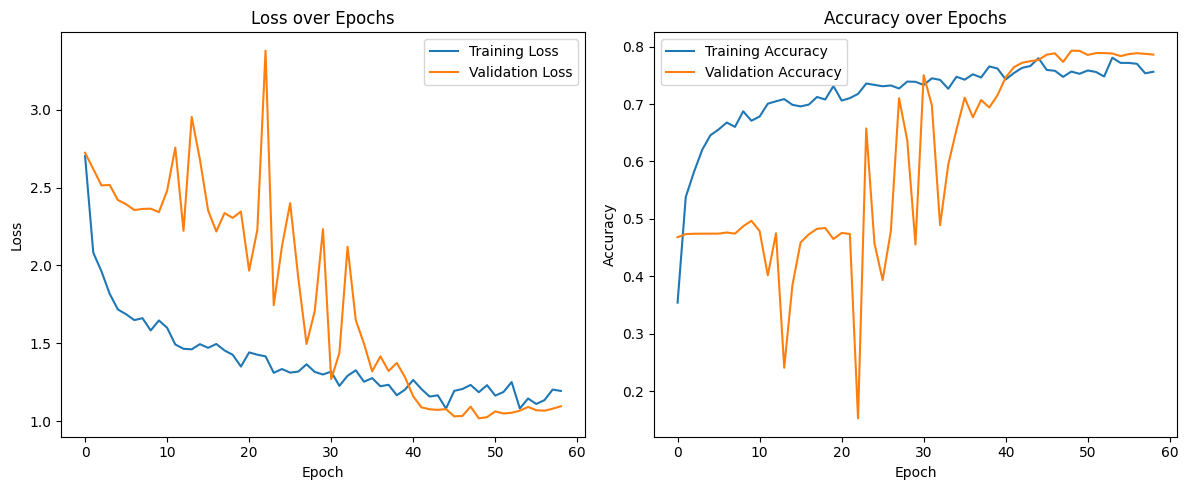

In [16]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
import tensorflow as tf

# Evaluate on validation set
val_loss, val_acc, val_iou = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Mean IoU (Jaccard Index): {val_iou:.4f}")

# Calculate Dice Coefficient (F1-Score)


dice_coeffs = []
for images, masks in val_ds:
    predictions = model.predict(images, verbose=0)
    # The dice_loss function expects one-hot encoded masks for y_true, and softmax output for y_pred.

    current_dice_loss = dice_loss(masks, predictions)
    dice_coeffs.append(1 - current_dice_loss)

avg_dice_coefficient = tf.reduce_mean(dice_coeffs).numpy()
print(f"Validation Dice Coefficient (F1-Score): {avg_dice_coefficient:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0728 - loss: 2.8019 - mean_io_u_2: 0.4286
Validation Loss: 2.8018
Validation Accuracy: 0.0817
Validation Mean IoU (Jaccard Index): 0.4286
Validation Dice Coefficient (F1-Score): 0.1430


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


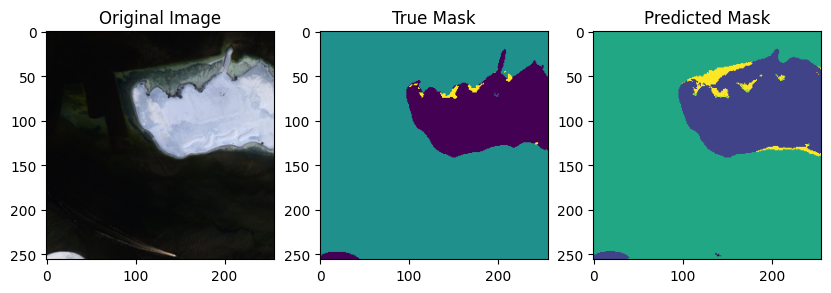

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Pick any image from validation set
idx = 5
test_img = X_val[idx]
test_mask = np.argmax(y_val[idx], axis=-1)

# Normalize and reshape
input_img = np.expand_dims(test_img, axis=0)

# Predict
pred = model.predict(input_img)
pred_mask = np.argmax(pred[0], axis=-1)

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(test_img)

plt.subplot(1,3,2)
plt.title("True Mask")
plt.imshow(test_mask)

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_mask)

plt.show()

In [19]:
model.save("cloud_segment_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [20]:
from google.colab import files
files.download("cloud_segment_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>